In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from collections import defaultdict
import argparse
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
import glob
import logging
import os
import sys
import time

from caffe2.python import workspace

from detectron.core.config import assert_and_infer_cfg
from detectron.core.config import cfg
from detectron.core.config import merge_cfg_from_file
from detectron.utils.io import cache_url
from detectron.utils.logging import setup_logging
from detectron.utils.timer import Timer
import detectron.core.test_engine as infer_engine
import detectron.datasets.dummy_datasets as dummy_datasets
import detectron.utils.c2 as c2_utils
from detectron.utils.vis import *

In [2]:
c2_utils.import_detectron_ops()

# OpenCL may be enabled by default in OpenCV3; disable it because it's not
# thread safe and causes unwanted GPU memory allocations.
cv2.ocl.setUseOpenCL(False)

Found Detectron ops lib: /home/jean/anaconda3/envs/caffenv/lib/python2.7/site-packages/torch/lib/libcaffe2_detectron_ops_gpu.so


In [3]:
def vis_one_image(
        im, im_name, output_dir, boxes, segms=None, keypoints=None, body_uv=None, thresh=0.9,
        kp_thresh=2, dpi=200, box_alpha=0.0, dataset=None, show_class=False,
        ext='pdf'):
    """Visual debugging of detections."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if isinstance(boxes, list):
        boxes, segms, keypoints, classes = convert_from_cls_format(
            boxes, segms, keypoints)

    if boxes is None or boxes.shape[0] == 0 or max(boxes[:, 4]) < thresh:
        return

    dataset_keypoints, _ = keypoint_utils.get_keypoints()

    if segms is not None and len(segms) > 0:
        masks = mask_util.decode(segms)

    color_list = colormap(rgb=True) / 255

    kp_lines = kp_connections(dataset_keypoints)
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]

    fig = plt.figure(frameon=False)
    fig.set_size_inches(im.shape[1] / dpi, im.shape[0] / dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.axis('off')
    fig.add_axes(ax)
    ax.imshow(im)

    # Display in largest to smallest order to reduce occlusion
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    sorted_inds = np.argsort(-areas)

    mask_color_id = 0
    for i in sorted_inds:
        bbox = boxes[i, :4]
        score = boxes[i, -1]
        if score < thresh:
            continue

        # show box (off by default)
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1],
                          fill=False, edgecolor='g',
                          linewidth=0.5, alpha=box_alpha))

        if show_class:
            ax.text(
                bbox[0], bbox[1] - 2,
                get_class_string(classes[i], score, dataset),
                fontsize=3,
                family='serif',
                bbox=dict(
                    facecolor='g', alpha=0.4, pad=0, edgecolor='none'),
                color='white')

        # show mask
        if segms is not None and len(segms) > i:
            img = np.ones(im.shape)
            color_mask = color_list[mask_color_id % len(color_list), 0:3]
            mask_color_id += 1

            w_ratio = .4
            for c in range(3):
                color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
            for c in range(3):
                img[:, :, c] = color_mask[c]
            e = masks[:, :, i]

            _, contour, hier = cv2.findContours(
                e.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

            for c in contour:
                polygon = Polygon(
                    c.reshape((-1, 2)),
                    fill=True, facecolor=color_mask,
                    edgecolor='w', linewidth=1.2,
                    alpha=0.5)
                ax.add_patch(polygon)

        # show keypoints
        if keypoints is not None and len(keypoints) > i:
            kps = keypoints[i]
            plt.autoscale(False)
            for l in range(len(kp_lines)):
                i1 = kp_lines[l][0]
                i2 = kp_lines[l][1]
                if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
                    x = [kps[0, i1], kps[0, i2]]
                    y = [kps[1, i1], kps[1, i2]]
                    line = plt.plot(x, y)
                    plt.setp(line, color=colors[l], linewidth=1.0, alpha=0.7)
                if kps[2, i1] > kp_thresh:
                    plt.plot(
                        kps[0, i1], kps[1, i1], '.', color=colors[l],
                        markersize=3.0, alpha=0.7)

                if kps[2, i2] > kp_thresh:
                    plt.plot(
                        kps[0, i2], kps[1, i2], '.', color=colors[l],
                        markersize=3.0, alpha=0.7)

            # add mid shoulder / mid hip for better visualization
            mid_shoulder = (
                kps[:2, dataset_keypoints.index('right_shoulder')] +
                kps[:2, dataset_keypoints.index('left_shoulder')]) / 2.0
            sc_mid_shoulder = np.minimum(
                kps[2, dataset_keypoints.index('right_shoulder')],
                kps[2, dataset_keypoints.index('left_shoulder')])
            mid_hip = (
                kps[:2, dataset_keypoints.index('right_hip')] +
                kps[:2, dataset_keypoints.index('left_hip')]) / 2.0
            sc_mid_hip = np.minimum(
                kps[2, dataset_keypoints.index('right_hip')],
                kps[2, dataset_keypoints.index('left_hip')])
            if (sc_mid_shoulder > kp_thresh and
                    kps[2, dataset_keypoints.index('nose')] > kp_thresh):
                x = [mid_shoulder[0], kps[0, dataset_keypoints.index('nose')]]
                y = [mid_shoulder[1], kps[1, dataset_keypoints.index('nose')]]
                line = plt.plot(x, y)
                plt.setp(
                    line, color=colors[len(kp_lines)], linewidth=1.0, alpha=0.7)
            if sc_mid_shoulder > kp_thresh and sc_mid_hip > kp_thresh:
                x = [mid_shoulder[0], mid_hip[0]]
                y = [mid_shoulder[1], mid_hip[1]]
                line = plt.plot(x, y)
                plt.setp(
                    line, color=colors[len(kp_lines) + 1], linewidth=1.0,
                    alpha=0.7)
                
    #   DensePose Visualization Starts!!
    ##  Get full IUV image out 
    IUV_fields = body_uv[1]
    #
    All_Coords = np.zeros(im.shape)
    All_inds = np.zeros([im.shape[0],im.shape[1]])
    K = 26
    ##
    inds = np.argsort(boxes[:,4])
    ##
    for i, ind in enumerate(inds):
        entry = boxes[ind,:]
        if entry[4] > 0.65:
            entry=entry[0:4].astype(int)
            ####
            output = IUV_fields[ind]
            ####
            All_Coords_Old = All_Coords[ entry[1] : entry[1]+output.shape[1],entry[0]:entry[0]+output.shape[2],:]
            All_Coords_Old[All_Coords_Old==0]=output.transpose([1,2,0])[All_Coords_Old==0]
            All_Coords[ entry[1] : entry[1]+output.shape[1],entry[0]:entry[0]+output.shape[2],:]= All_Coords_Old
            ###
            CurrentMask = (output[0,:,:]>0).astype(np.float32)
            All_inds_old = All_inds[ entry[1] : entry[1]+output.shape[1],entry[0]:entry[0]+output.shape[2]]
            All_inds_old[All_inds_old==0] = CurrentMask[All_inds_old==0]*i
            All_inds[ entry[1] : entry[1]+output.shape[1],entry[0]:entry[0]+output.shape[2]] = All_inds_old
    #
    All_Coords[:,:,1:3] = 255. * All_Coords[:,:,1:3]
    All_Coords[All_Coords>255] = 255.
    All_Coords = All_Coords.astype(np.uint8)
    All_inds = All_inds.astype(np.uint8)
    #
    IUV_SaveName = os.path.basename(im_name).split('.')[0]+'.png'
    INDS_SaveName = os.path.basename(im_name).split('.')[0]+'_INDS.png'
    IUV_path = os.path.join(output_dir, '{}'.format(IUV_SaveName))
    INDS_path = os.path.join(output_dir, '{}'.format(INDS_SaveName))
    cv2.imwrite(IUV_path, All_Coords )
    #cv2.imwrite(INDS_path, All_inds )
    print('IUV_path: ', IUV_path)
    print('INDS_path: ', INDS_path)
    #print('IUV written to: ' , os.path.join(output_dir, '{}'.format(IUV_SaveName)) )
    ###
    ### DensePose Visualization Done!!
    #
    output_name = os.path.basename(im_name) + '.' + ext
    #fig.savefig(os.path.join(output_dir, '{}'.format(output_name)), dpi=dpi)
    return fig


In [ ]:
nude_imgs_path = '/home/jean/bazar/data/128x128/dressed/'
background_path = '/home/jean/bazar/data/128x128/cropped/'

In [5]:
logger = logging.getLogger(__name__)
merge_cfg_from_file('../configs/DensePose_ResNet101_FPN_s1x-e2e.yaml')
cfg.NUM_GPUS = 1
weights = cache_url('https://s3.amazonaws.com/densepose/DensePose_ResNet101_FPN_s1x-e2e.pkl', cfg.DOWNLOAD_CACHE)
assert_and_infer_cfg(cache_urls=False)
model = infer_engine.initialize_model_from_cfg(weights)
dummy_coco_dataset = dummy_datasets.get_coco_dataset()

In [6]:
im_list = ['../../data/640x640/test/{}.png'.format(x) for x in range(29)]
for i, im_name in enumerate(im_list):
    out_name = os.path.join(
        '{}'.format(os.path.basename(im_name) + '.pdf')
    )
    logger.info('Processing {} -> {}'.format(im_name, out_name))
    im = cv2.imread(im_name)
    timers = defaultdict(Timer)
    t = time.time()
    with c2_utils.NamedCudaScope(0):
        cls_boxes, cls_segms, cls_keyps, cls_bodys = infer_engine.im_detect_all(
            model, im, None, timers=timers
        )
    logger.info('Inference time: {:.3f}s'.format(time.time() - t))
    for k, v in timers.items():
        logger.info(' | {}: {:.3f}s'.format(k, v.average_time))
    if i == 0:
        logger.info(
            ' \ Note: inference on the first image will be slower than the '
            'rest (caches and auto-tuning need to warm up)'
        )

    fig = vis_one_image(
        im[:, :, ::-1],  # BGR -> RGB for visualization
        im_name,
        "../../data/640x640/cropped/test/pose",
        cls_boxes,
        cls_segms,
        cls_keyps,
        cls_bodys,
        dataset=dummy_coco_dataset,
        box_alpha=0.3,
        show_class=True,
        thresh=0.7,
        kp_thresh=2
    )

IUV_path:  ../../data/640x640/cropped/test/pose/0.png
INDS_path:  ../../data/640x640/cropped/test/pose/0_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/1.png
INDS_path:  ../../data/640x640/cropped/test/pose/1_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/2.png
INDS_path:  ../../data/640x640/cropped/test/pose/2_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/3.png
INDS_path:  ../../data/640x640/cropped/test/pose/3_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/4.png
INDS_path:  ../../data/640x640/cropped/test/pose/4_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/5.png
INDS_path:  ../../data/640x640/cropped/test/pose/5_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/6.png
INDS_path:  ../../data/640x640/cropped/test/pose/6_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/7.png
INDS_path:  ../../data/640x640/cropped/test/pose/7_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/8.png
INDS_path:  ../../data/640x640/cro

/home/jean/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


IUV_path:  ../../data/640x640/cropped/test/pose/20.png
INDS_path:  ../../data/640x640/cropped/test/pose/20_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/21.png
INDS_path:  ../../data/640x640/cropped/test/pose/21_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/22.png
INDS_path:  ../../data/640x640/cropped/test/pose/22_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/23.png
INDS_path:  ../../data/640x640/cropped/test/pose/23_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/24.png
INDS_path:  ../../data/640x640/cropped/test/pose/24_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/25.png
INDS_path:  ../../data/640x640/cropped/test/pose/25_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/26.png
INDS_path:  ../../data/640x640/cropped/test/pose/26_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/27.png
INDS_path:  ../../data/640x640/cropped/test/pose/27_INDS.png
IUV_path:  ../../data/640x640/cropped/test/pose/28.png
INDS_path:  ../..

In [116]:
print(cls_boxes)

[[], array([[2.48655884e+02, 8.34387207e+00, 4.82956909e+02, 6.30689392e+02,
        9.99857664e-01],
       [5.40569702e+02, 9.08879471e+01, 6.28148926e+02, 1.21974052e+02,
        8.75734866e-01],
       [2.26636887e+02, 4.53066330e+01, 2.40360611e+02, 6.73507843e+01,
        7.20773935e-01],
       [2.45440079e+02, 4.93214798e+01, 2.60243469e+02, 7.21695709e+01,
        4.70973521e-01],
       [2.39172302e+02, 6.25673523e+01, 2.62039307e+02, 8.50660095e+01,
        1.38968796e-01],
       [2.57029175e+02, 6.79438705e+01, 2.68865540e+02, 8.40267563e+01,
        4.84503537e-01],
       [2.26059158e+02, 4.31762657e+01, 2.36360031e+02, 5.91775093e+01,
        1.31600544e-01],
       [2.67658722e+02, 4.77784233e+01, 2.72731476e+02, 5.48754845e+01,
        1.39179945e-01],
       [2.39250641e+02, 4.81108017e+01, 2.46872681e+02, 6.85410004e+01,
        1.10137828e-01],
       [4.95564758e+02, 3.98760681e+01, 5.06432739e+02, 7.74075317e+01,
        2.17716530e-01],
       [2.37773788e+02, 5

In [9]:
from PIL import Image

In [10]:
import matplotlib.pyplot as plt

In [71]:
pose = cv2.imread('test/4230_IUV.png')
im  = cv2.imread('4230.png')

In [72]:
person = np.zeros(im.shape)

In [76]:
for row in range(im.shape[0]):
    for pix in range(im.shape[1]):
        if pose[row][pix].all() != np.repeat(0,3).all():
            person[row][pix] = im[row][pix]

In [109]:
o = np.hstack((pose[:,:,0]/24. ,pose[:,:,1]/256. ,pose[:,:,2]/256.))

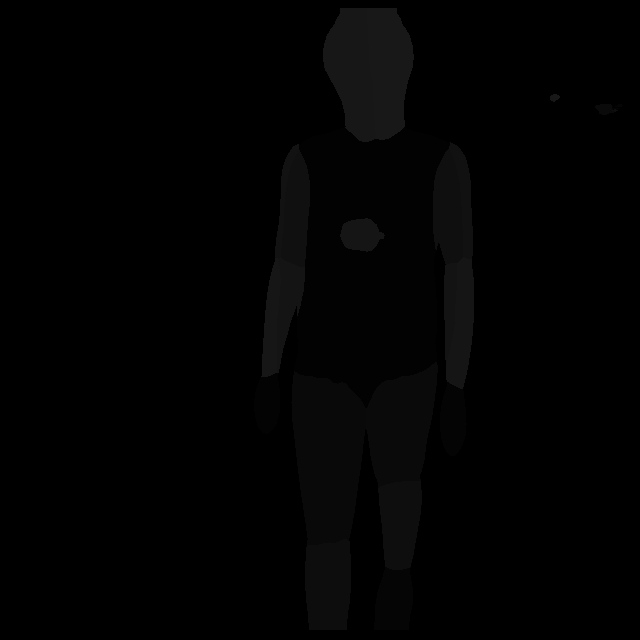

In [113]:
Image.fromarray(pose[,:,0])

In [ ]:
background = np.zeros(im.shape)
for row in range(im.shape[0]):
    for pix in range(im.shape[1]):
        

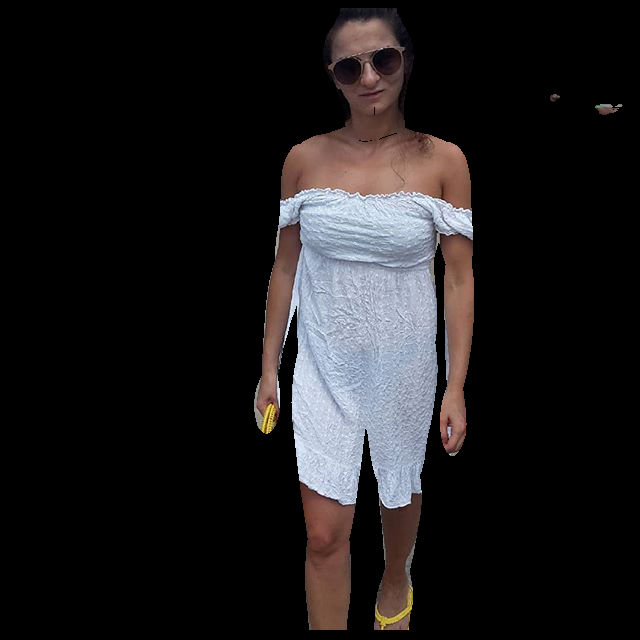

In [80]:
Image.fromarray(person[:,:,::-1].astype('uint8'))

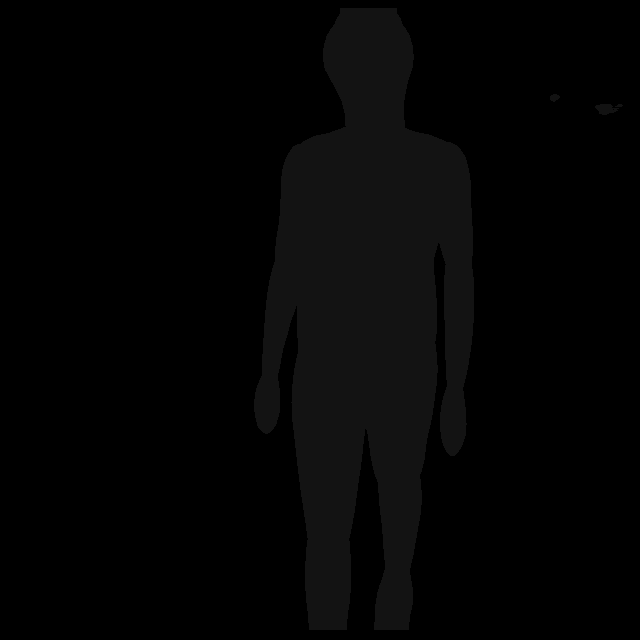

In [28]:
Image.open('test/4230_INDS.png')

In [5]:
import numpy as np

In [81]:
im  = cv2.imread('4230.png')
IUV = cv2.imread('test/4230_IUV.png')
INDS = cv2.imread('test/4230_INDS.png',  0)

/home/jean/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


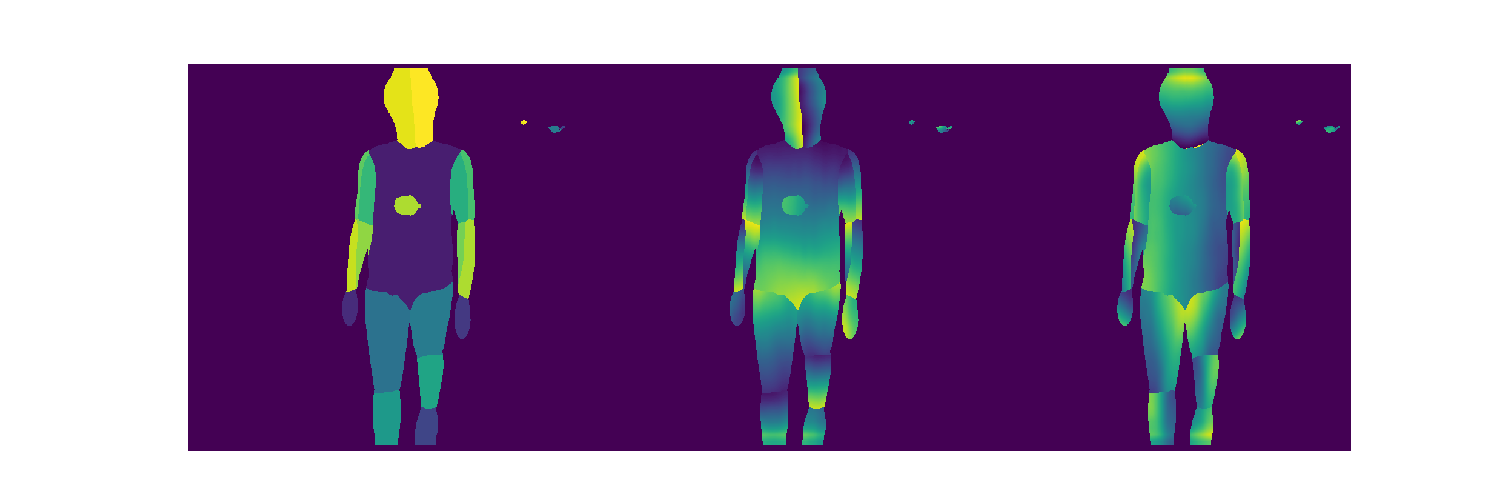

In [82]:
fig = plt.figure(figsize=[15,15])
plt.imshow(   np.hstack((IUV[:,:,0]/24. ,IUV[:,:,1]/256. ,IUV[:,:,2]/256.))  )
#plt.title('I, U and V images.')
plt.axis('off')
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
o = data.reshape((1500,1500,3))
o = o[500:1000,:,:]
o1 = o[:,:500,:]
o2 = o[:,500:1000,:]
o3 = o[:,1000:1500,:]
Image.fromarray(o)

In [104]:
Image.fromarray(o1[90:100,425:435,:])

In [105]:
o1[90:100,425:435,:]

array([[[253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36]],

       [[253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36]],

       [[253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36]],

       [[253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231,  36],
        [253, 231, 

In [67]:
[228, 227,  24], [253, 231,  36]

(500, 500, 3)

In [41]:
Image.fromarray(o.reshape(640,640,1))

TypeError: Cannot handle this data type

In [35]:
f = np.zeros(im.shape)

/home/jean/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


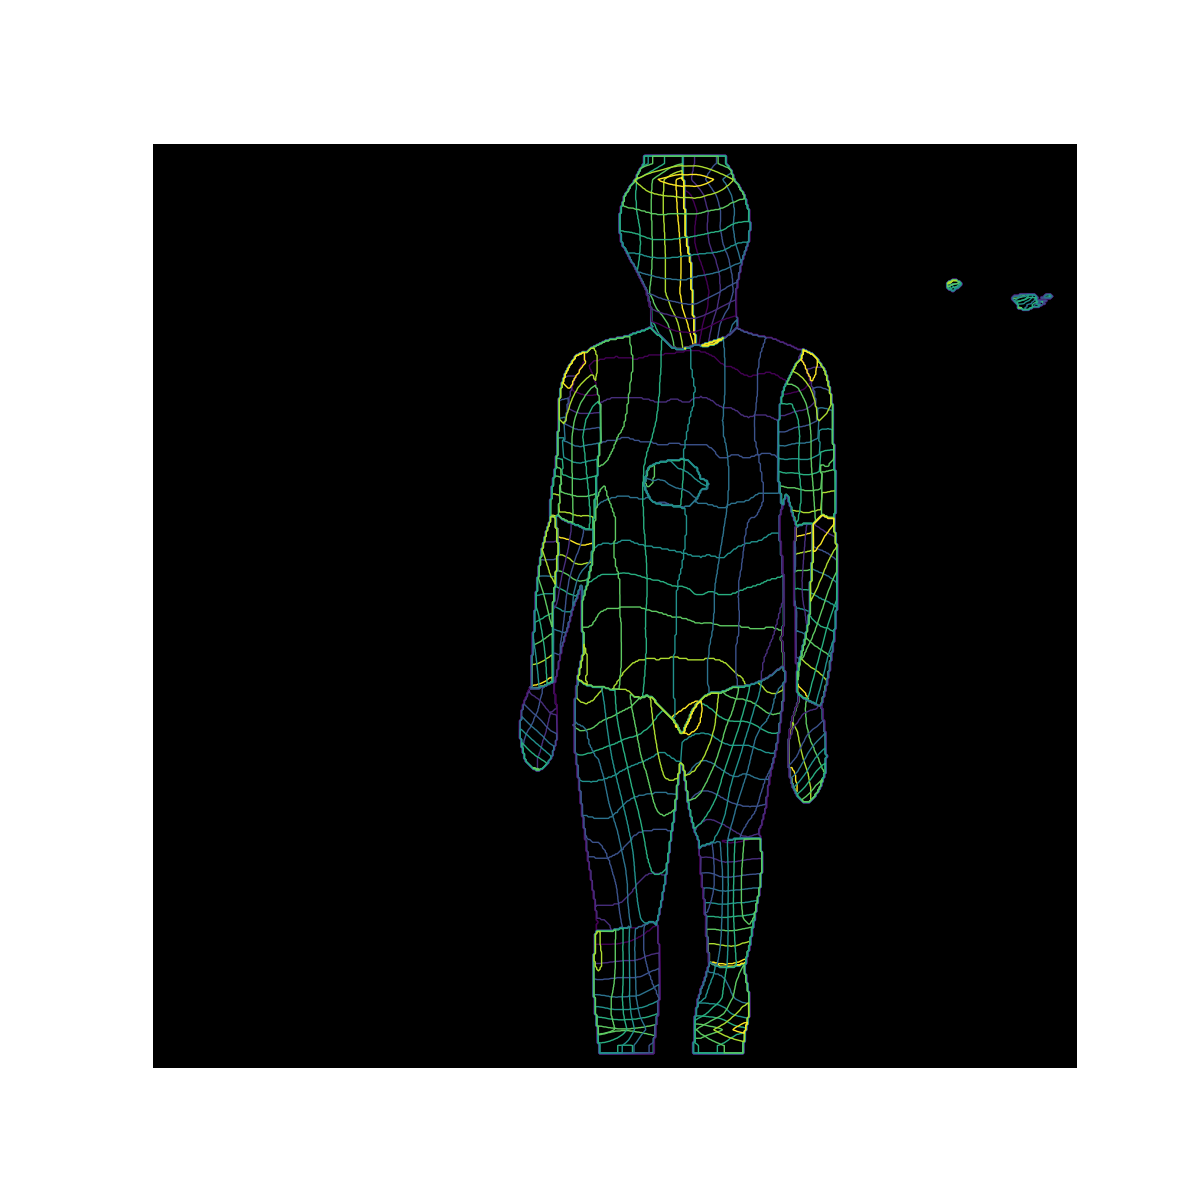

In [36]:
fig = plt.figure(figsize=[12,12])
plt.imshow( f[:,:,::-1] )
plt.contour( IUV[:,:,1]/256.,10, linewidths = 1 )
plt.contour( IUV[:,:,2]/256.,10, linewidths = 1 )
plt.axis('off')
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
o = data.reshape((1200,1200,3))
Image.fromarray(o)

/home/jean/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


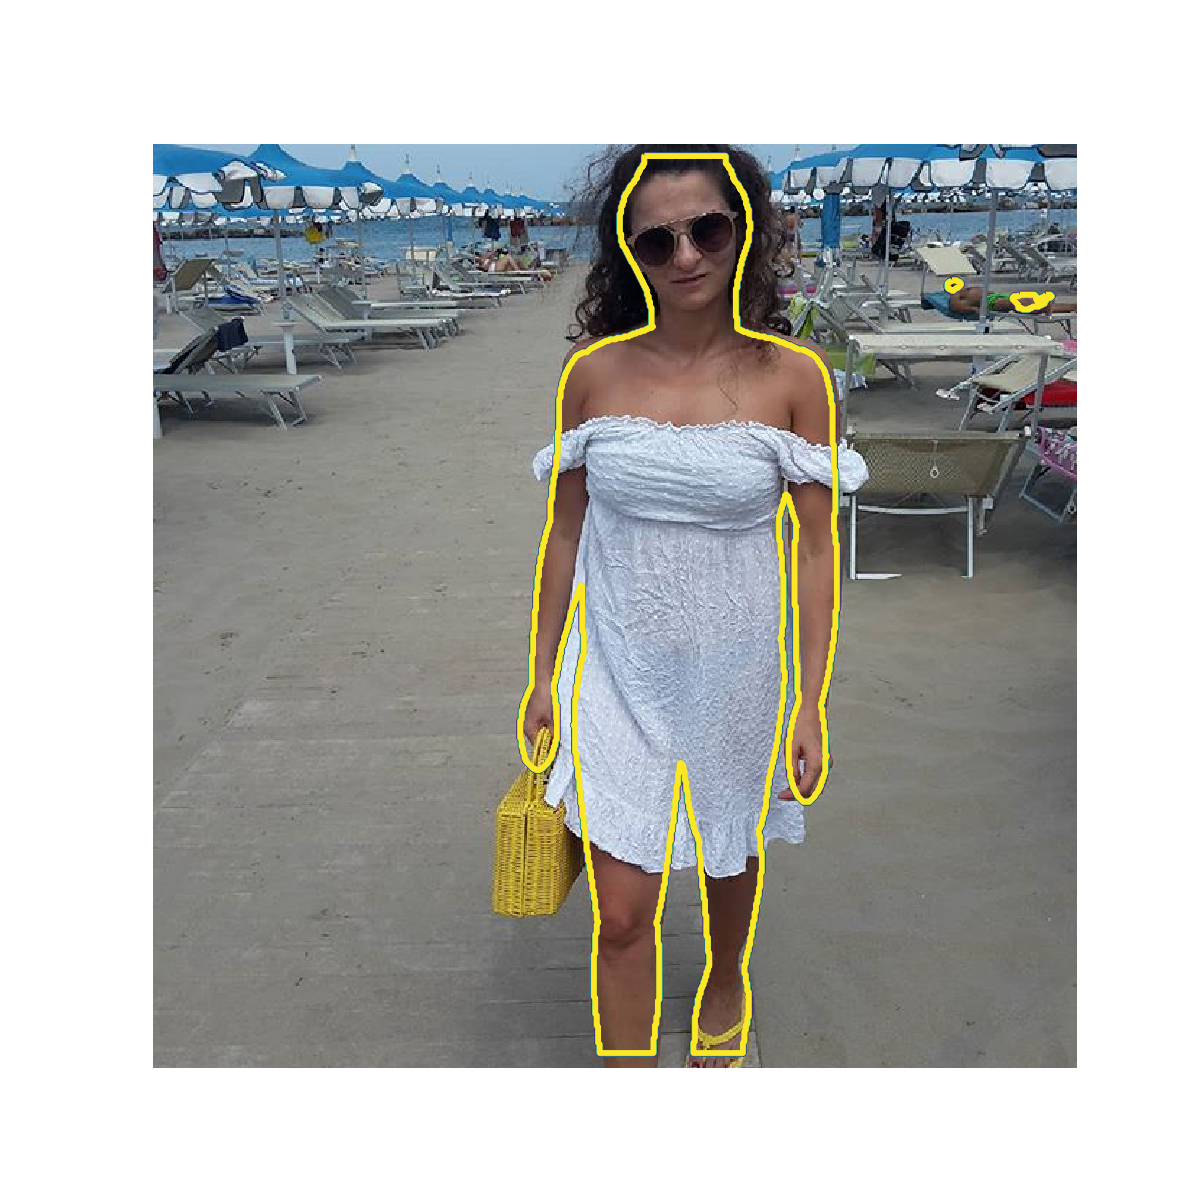

In [37]:
fig = plt.figure(figsize=[12,12])
plt.imshow( im[:,:,::-1] )
plt.contour( INDS, linewidths = 4 )
plt.axis('off')
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
o = data.reshape((1200,1200,3))
Image.fromarray(o)